# Redshift Distribution
The following notebook plots the (spectroscopic) redshift distribution of the KiDS galaxies in Christoph's catalog, according to the tomographic redshift bins defined in Hildebrant et al 2021. 

Catalogs used: 
* lensing_cosmos_extended.fits (Christoph)
* lensing_vvds_extended.fits (Christoph)
* COSMOSadaptdepth_ugriZYJHKs_rot_photoz.cat (KiDS)

In [81]:
# import functions

import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages') #minisom location

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack, Column

import h5py

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from minisom import MiniSom

import numpy as np

In [82]:
# functions 
# upon next iteration, create a python script to hold these 
def vertical_stack(catalog_1, catalog_2, id_1, id_2): 
    """ 
    Stacks two catalogs vertically, retaining origin information. 
    
    Parameters 
    ----------
    catalog_1: (astropy.Table)
        The first catalog in the stack.
    catalog_2: (astropy.Table)
        The second catalog in the stack. 
    id_1: (str)
        The identifying information for the first catalog. (i.e., catalog name?)
    id_2: (str)
        The identifying information for the second catalog. 
        
    Returns
    -------
        
    """
    
    # add a column to both catalog 1 and catalog 2 to store identifiers
    # initialize columns
    col_1 = Column(name = 'catalog_name', data = np.full(len(catalog_1), str(id_1))) 
    col_2 = Column(name = 'catalog_name', data = np.full(len(catalog_2), str(id_2)))
    
    # add columns to catalogs
    catalog_1.add_column(col_1)
    catalog_2.add_column(col_2)
    
    # vertically stack catalogs 
    stacked_catalog = vstack((catalog_1, catalog_2))
    
    return stacked_catalog

def convert_coordinates(catalog): 
    """
    Converts the Ra and Dec in the catalog from (hourangle, degree) to (degree, degree). 
    
    Parameters
    ----------
    catalog: (astropy.Table)
        Catalog requiring conversion. 
    
    Returns
    -------
    catalog: (astropy.Table)
        Catalog with additional columns holding converted positions. 
    """

    ra_h = np.array(catalog['RAh'])
    ra_m = np.array(catalog['RAm'])
    ra_s = np.array(catalog['RAs'])
    dec_sign = np.array(catalog['DE-'])
    dec_d = np.array(catalog['DEd'])
    dec_m = np.array(catalog['DEm'])
    dec_s = np.array(catalog['DEs'])
    coords_list = [] 

    # store coord into SkyCoord for easier conversion to deg + comparison with HSC 
    coords_list = [SkyCoord(f'{ra_h[i]}h{ra_m[i]}m{ra_s[i]}s', f'{dec_sign[i]}{dec_d[i]}d{dec_m[i]}m{dec_s[i]}s', unit = (u.hourangle, u.deg)) for i, obj in enumerate(catalog)]
    col_ra = [Column(name = 'RAd', data = coords_list[i].ra*u.deg/u.deg) for i, obj in enumerate(catalog)]
    col_dec = [Column(name = 'DEd', data = coords_list[i].dec*u.deg/u.deg) for i, obj in enumerate(catalog)]

    # add columns to catalog 
    catalog.add_column(col_ra*u.deg, name = 'RAdeg')
    catalog.add_column(col_dec*u.deg, name = 'DEdeg')

    return catalog

def get_ra_dec(catalog, ra_str, dec_str): 
    """
    Creates list of RA and Decs for the input catalog.
    
    Parameters 
    ----------
    catalog : (astropy.Table)
        An astropy Table containing the catalog. 
    ra_str : (str)
        String used for RA header
    dec_str : str
        String used for the Dec header
        
    Returns
    -------
    ra : (list)
        List containing the RAs of objects.
    dec : (list)
        List containing the Decs of the objects. 
    
    """
    ra = list(catalog[ra_str])
    dec = list(catalog[dec_str])
    
    return(ra, dec)

def create_sky_coord(ra, dec, deg = True, ra_u = None, dec_u = None): 
    """
    Creates SkyCoord object for match_catalogs function. 
    
    Parameters 
    ----------
    ra : (list) or (str)
        List containing RAs of the objects. 
        Or RA of the object.
    dec : (list) or (str)
        List containing Decs of the objects. 
        Or Dec of the object. 
    deg : (bool)
        Is the coordinate already in degrees?
    ra_u : (astropy.unit) or (None)
        RA unit.
    dec_u : (astropy.unit) or (None)
        Dec unit. 
        
    
    Returns 
    -------
    sky_coord : (astropy.coordinates.SkyCoord)
        SkyCoord object containing positional information, 
        including units and separation (dimensionless, set to 1).
    """
    if deg == True: 
        sky_coord = SkyCoord(ra*u.deg, dec*u.deg)
    else: 
        sky_coord = SkyCoord(ra, dec, unit = (ra_u, dec_u))
    
    return sky_coord

def match_catalogs(catalog1_coord, catalog2_coord): 
    """
    Matches two catalogs based on coordinates. 
    Note: Assumes coords are in RA and Dec (degrees). 
    
    Parameters 
    ----------
    catalog1_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 1
    catalog2_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 2
        
    Return
    ------
    idx : (list)
        Indices into catalog2_coord that are the closest objects 
        to each of the coordinates in catalog1_coord
    d2d : (list)
        On-sky distances between them 
    d3d : (list)
        3D distances between them
    """
    idx, d2d, d3d = catalog1_coord.match_to_catalog_sky(catalog2_coord)
    
    return idx, d2d, d3d

def get_matches(max_sep, catalog1_coord, catalog2_coord, catalog1, catalog2): 
    """
    Matches two catalogs based on coordinates using match_catalogs. 
    Prints matches considering separation constraint. 
    
    Parameters 
    ----------
    max_sep : (float)
        Maximum separation to be considered a match (arcsec)
    catalog1_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 1
    catalog2_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 2    
    
    Return
    ------
    catalog1_matches : (list)
        List containing matched sources separated by less than 
        max_sep in catalog1
    catalog2_matches : (list)
        List containing matched sources separated by less than 
        max_sep in catalog2
    """
    # add units to max separation 
    max_sep = max_sep * u.arcsec
    idx, d2d, d3d = match_catalogs(catalog1_coord, catalog2_coord)
    separation_constraint = d2d < max_sep 
    
    catalog1_matches = catalog1[separation_constraint]
    catalog2_matches = catalog2[idx[separation_constraint]]
    
    return catalog1_matches, catalog2_matches

In [83]:
# data path 
specz_path = '/Users/diana/Research/DESI-SOM/data/Specz'
kids_path = '/Users/diana/Research/DESI-SOM/data/KiDS'

In [84]:
# import data 
c3r2_cosmos_table = Table.read(f'{specz_path}/lensing_cosmos_extended.fits')
c3r2_vvds_table = Table.read(f'{specz_path}/lensing_vvds_extended.fits')

kids_table = Table.read(f'{kids_path}/COSMOSadaptdepth_ugriZYJHKs_rot_photoz.cat')

# vertically stack c3r2 tables
c3r2_table = vertical_stack(c3r2_cosmos_table, c3r2_vvds_table, 'lensing_cosmos_extended.fits', 'lensing_vvds_extended.fits')

# remove galaxies with neither photoz nor specz
c3r2_table = c3r2_table[np.where(c3r2_table['has_z_spec'] == True)]

In [85]:
# create SkyCoord for each catalog
# obtain ra and dec for each catalog
c3r2_table_ra, c3r2_table_dec = get_ra_dec(c3r2_table, 'RA', 'DEC')
kids_table_ra, kids_table_dec = get_ra_dec(kids_table, 'ALPHA_J2000', 'DELTA_J2000')

# create SkyCoord object for each catalog
c3r2_table_sky_coord = create_sky_coord(c3r2_table_ra, c3r2_table_dec) 
kids_table_sky_coord = create_sky_coord(kids_table_ra, kids_table_dec) 

# find matches 
c3r2_kids_idx, c3r2_kids_d2d, c3r2_kids_d3d = match_catalogs(c3r2_table_sky_coord, kids_table_sky_coord)

# print matches
# obtain matches within 1 arcsec
c3r2_kids_matches, kids_c3r2_matches = get_matches(1, c3r2_table_sky_coord, kids_table_sky_coord, c3r2_table, kids_table)
print(f'There are {len(c3r2_kids_matches)} matches in C3R2 x KiDS.') # note this is KiDS in COSMOS

There are 78812 matches in C3R2 x KiDS.


In [86]:
# visualize redshift matches
# plot photoz vs specz 
# set style
#plt.style.use('classic')

#fig, ax = plt.subplots(figsize = (5,5), dpi = 300) # make figure larger and more HD

# plot data
#plt.scatter(c3r2_kids_matches['z_spec'], kids_c3r2_matches['Z_B'], s = 2, alpha = 0.3)

In [62]:
# create bins
#bin_1 = c3r2_kids_matches[np.where(np.logical_and( (c3r2_kids_matches['z_spec'] > 0.1), (c3r2_kids_matches['z_spec'] <= 0.3)))]
#bin_2 = c3r2_kids_matches[np.where(np.logical_and( (c3r2_kids_matches['z_spec'] > 0.3), (c3r2_kids_matches['z_spec'] <= 0.5)))]
#bin_3 = c3r2_kids_matches[np.where(np.logical_and( (c3r2_kids_matches['z_spec'] > 0.5), (c3r2_kids_matches['z_spec'] <= 0.7)))]
#bin_4 = c3r2_kids_matches[np.where(np.logical_and( (c3r2_kids_matches['z_spec'] > 0.7), (c3r2_kids_matches['z_spec'] <= 0.9)))]
#bin_5 = c3r2_kids_matches[np.where(np.logical_and( (c3r2_kids_matches['z_spec'] > 0.9), (c3r2_kids_matches['z_spec'] <= 1.2)))]                 

In [73]:

# plot distributions according to bin
# understanding how the matches change with matching radius 
#bins = [bin_1, bin_2, bin_3, bin_4, bin_5]
#bins_names = ['$0.1<Z_{B} \leq 0.3$', '$0.3<Z_{B} \leq 0.5$', '$0.5<Z_{B} \leq 0.7$', '$0.7<Z_{B} \leq 0.9$', '$0.9<Z_{B} \leq 1.2$']
#fig,ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
#plt_ind = np.arange(5) + 151

#i = 0
#for binss, ind in zip(bins, plt_ind):
#    plt.subplot(ind);
#    
#    #photoz_specz_matches, specz_photoz_matches = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
#   plt.hist(binss['z_spec'])
#    #print(f'There are {len(photoz_specz_matches)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')
    
#    # plot x = y 
#    #points = np.linspace(0, 4, 50)
#    #plt.plot(points, points, c = 'k')
#    
#    plt.title(bins_names[i])
#    #plt.xlabel('spec-z')
#    #plt.ylabel('photo-z')
    
#    plt.xlim((0,1.5))
#    #plt.ylim((0,4))

#    fig.subplots_adjust(hspace=0.5, wspace=0.3)
#    i+=1
    
#plt.show()
#plt.savefig('photo-z_vs_spec-z_matching_radius.png')

In [87]:
# here, we are binning by Z_B
# create bins
bin_1 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.1), (kids_c3r2_matches['Z_B'] <= 0.3)))]
bin_2 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.3), (kids_c3r2_matches['Z_B'] <= 0.5)))]
bin_3 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.5), (kids_c3r2_matches['Z_B'] <= 0.7)))]
bin_4 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.7), (kids_c3r2_matches['Z_B'] <= 0.9)))]
bin_5 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.9), (kids_c3r2_matches['Z_B'] <= 1.2)))]                 

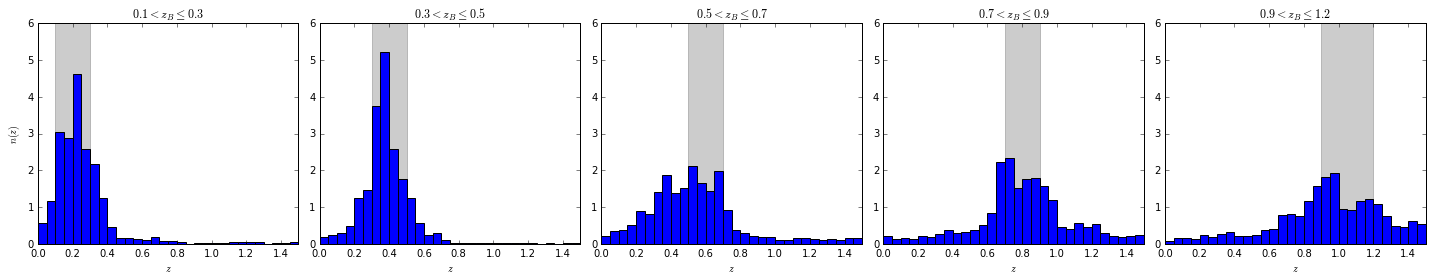

In [88]:
# plot distributions according to bin
bins = [bin_1, bin_2, bin_3, bin_4, bin_5]
bins_names = ['$0.1<z_{B} \leq 0.3$', '$0.3<z_{B} \leq 0.5$', '$0.5<z_{B} \leq 0.7$', '$0.7<z_{B} \leq 0.9$', '$0.9<z_{B} \leq 1.2$']
bins_ranges = [(0.1, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.2)]

fig,ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
plt_ind = np.arange(5) + 151

i = 0
for binss, ind in zip(bins, plt_ind):
    plt.subplot(ind);
    
    plt.axvspan(bins_ranges[i][0], bins_ranges[i][1], color='black', alpha=0.2)
    
    #photoz_specz_matches, specz_photoz_matches = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
    plt.hist(binss['z_spec'], bins = 30, range = (0., 1.5), density = True)
    #print(f'There are {len(photoz_specz_matches)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')
    
    plt.title(bins_names[i])
    
    if i == 0: 
        plt.ylabel('$n(z)$')
    
    plt.xlabel('$z$')
    
    # limits
    plt.xlim((0,1.5))
    plt.ylim((0,6))

    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    i+=1
    
#plt.show()
plt.tight_layout()
plt.savefig('c3r2_kids_redshift_distribution.png')